## Taxi Trip Duration
1. Frame the problem and look at the big picture
2. Get the data
3. Explore the data to gain insights
4. Prepare the data to better expose the underlying data patterns to machine learning algorithms
5. Explore many different models and short-list the best ones
6. Fine-tune your models and combine them into a great solution
7. Present your solution
8. Launch, monitor and maintain your system


## Frame the problem and look at the big picture

The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. 
In this project the goal is to make a model based on individual trip attributes, to be able to predict the duration of each trip in the test set.


## Get the data

In [1]:
# get data for dataset

# Common imports
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import os
import tarfile
from six.moves import urllib

TAXI_PATH = os.path.join("data", "taxi")

def load_taxi_data(taxi_path=TAXI_PATH):
    csv_path = os.path.join(taxi_path, "train.csv")
    return pd.read_csv(csv_path)

import warnings
warnings.filterwarnings(action="ignore", message="^RuntimeWarning")

In [2]:
taxi = load_taxi_data()
csv_path = os.path.join(TAXI_PATH, "test.csv")
test_set = pd.read_csv(csv_path)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [3]:
taxi_samples = taxi.sample(frac=0.10)
taxi_samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145864 entries, 67250 to 657429
Data columns (total 11 columns):
id                    145864 non-null object
vendor_id             145864 non-null int64
pickup_datetime       145864 non-null object
dropoff_datetime      145864 non-null object
passenger_count       145864 non-null int64
pickup_longitude      145864 non-null float64
pickup_latitude       145864 non-null float64
dropoff_longitude     145864 non-null float64
dropoff_latitude      145864 non-null float64
store_and_fwd_flag    145864 non-null object
trip_duration         145864 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 13.4+ MB


In [4]:
taxi_samples.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
67250,id2793718,2,2016-06-08 07:36:19,2016-06-08 07:53:39,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1397036,id3485529,2,2016-04-03 12:58:11,2016-04-03 13:11:58,1,-73.978394,40.764351,-73.991623,40.749859,N,827
1021087,id1816614,2,2016-06-05 02:49:13,2016-06-05 02:59:27,5,-73.989059,40.744389,-73.973381,40.748692,N,614
951424,id1050851,2,2016-05-05 17:18:27,2016-05-05 17:32:54,2,-73.990326,40.731136,-73.991264,40.748917,N,867
707882,id0140657,1,2016-05-12 17:43:38,2016-05-12 19:06:25,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


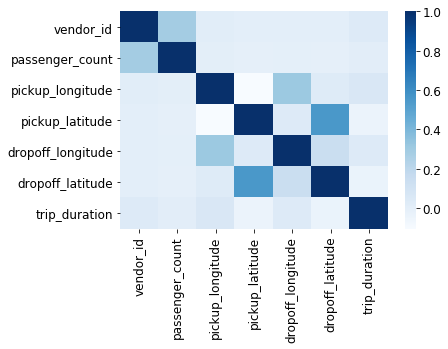

In [5]:
import seaborn as sns
sns.heatmap(taxi_samples.corr(), cmap='Blues')

In [6]:
data_labels = list(taxi_samples)
data_y = {'trip_duration': taxi_samples.iloc[:,10]}
X = pd.DataFrame(data=taxi_samples.iloc[:, :-1].values, columns=data_labels[:10])
y = pd.DataFrame(data_y)
X.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id2793718,2,2016-06-08 07:36:19,2016-06-08 07:53:39,1,-73.9856,40.7359,-73.9803,40.7605,N
1,id3485529,2,2016-04-03 12:58:11,2016-04-03 13:11:58,1,-73.9784,40.7644,-73.9916,40.7499,N
2,id1816614,2,2016-06-05 02:49:13,2016-06-05 02:59:27,5,-73.9891,40.7444,-73.9734,40.7487,N
3,id1050851,2,2016-05-05 17:18:27,2016-05-05 17:32:54,2,-73.9903,40.7311,-73.9913,40.7489,N
4,id0140657,1,2016-05-12 17:43:38,2016-05-12 19:06:25,4,-73.7895,40.6467,-73.9871,40.7592,N


In [7]:
y.head()

,trip_duration
67250,1040
1397036,827
1021087,614
951424,867
707882,4967


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state=42)
X_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
47726,id1300757,2,2016-05-04 18:36:52,2016-05-04 19:16:56,1,-73.8709,40.7738,-73.9787,40.7625,N
83469,id3121281,2,2016-05-20 01:44:40,2016-05-20 01:59:37,2,-73.9932,40.6827,-73.9529,40.6525,N
113890,id0447166,2,2016-01-26 11:56:04,2016-01-26 12:04:18,3,-73.9475,40.7906,-73.9594,40.7829,N
395,id1301295,1,2016-02-19 11:08:22,2016-02-19 11:36:11,1,-74.0099,40.7211,-73.8727,40.7743,N
115060,id3613539,2,2016-04-25 16:55:55,2016-04-25 17:07:06,2,-74.0072,40.7054,-73.9652,40.7577,N


In [9]:
print(len(X_train), "train +", len(y_val), "test")

102104 train + 43760 test


In [10]:
import folium # goelogical map
newyork_map = folium.Map(location=[40.767937,-73.982155 ], tiles='OpenStreetMap', zoom_start=12)

In [11]:
def createMap(geo_map, data, i=10):
    for each in X_train[:i].iterrows():
        p1 = [each[1]['pickup_latitude'] ,each[1]['pickup_longitude']]
        p2 = [each[1]['dropoff_latitude'], each[1]['dropoff_longitude']]
        folium.CircleMarker(p1,
                            radius=3,
                            color='blue',
                            popup=str(each[1]['pickup_latitude'])+','+str(each[1]['pickup_longitude']),
                            fill_color='#FD8A6C'
                            ).add_to(geo_map)
        folium.CircleMarker(p2,
                            radius=3,
                            color='red',
                            popup=str(each[1]['dropoff_latitude'])+','+str(each[1]['dropoff_longitude']),
                            fill_color='#FD8A6C'
                            ).add_to(geo_map)
        folium.PolyLine(locations=[p1, p2], color='green').add_to(geo_map)
    
createMap(newyork_map, X_train)

newyork_map

In [12]:
import mpu

def calculateDistances(data, distances):
    for each in data.iterrows():
        lat1 = float(each[1]['pickup_latitude'])
        lon1 = float(each[1]['pickup_longitude'])
        lat2 = float(each[1]['dropoff_latitude'])
        lon2 = float(each[1]['dropoff_longitude'])
        dist = mpu.haversine_distance((lat1, lon1), (lat2, lon2))
        distances.append(dist)
        

distances = []
calculateDistances(X_train, distances)

distances = np.array(distances)
X_train_copy = X_train.copy()
X_train_copy['distance'] = distances
X_train_copy.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance
47726,id1300757,2,2016-05-04 18:36:52,2016-05-04 19:16:56,1,-73.8709,40.7738,-73.9787,40.7625,N,9.161363
83469,id3121281,2,2016-05-20 01:44:40,2016-05-20 01:59:37,2,-73.9932,40.6827,-73.9529,40.6525,N,4.780321
113890,id0447166,2,2016-01-26 11:56:04,2016-01-26 12:04:18,3,-73.9475,40.7906,-73.9594,40.7829,N,1.318140
395,id1301295,1,2016-02-19 11:08:22,2016-02-19 11:36:11,1,-74.0099,40.7211,-73.8727,40.7743,N,12.989188
115060,id3613539,2,2016-04-25 16:55:55,2016-04-25 17:07:06,2,-74.0072,40.7054,-73.9652,40.7577,N,6.810164


In [13]:

#time

X_train_copy['wday']                 = pd.to_datetime(X_train_copy.pickup_datetime).dt.dayofweek.astype('uint8')
X_train_copy['day']                  = pd.to_datetime(X_train_copy.pickup_datetime).dt.day.astype('uint8')
X_train_copy['hour']                 = pd.to_datetime(X_train_copy.pickup_datetime).dt.hour.astype('uint8')
X_train_copy['minute']               = pd.to_datetime(X_train_copy.pickup_datetime).dt.minute.astype('uint8')
X_train_copy['second']               = pd.to_datetime(X_train_copy.pickup_datetime).dt.second.astype('uint8')
X_train_copy["doy"]                  = pd.to_datetime(X_train_copy.pickup_datetime).dt.dayofyear.astype('uint8')

X_train_copy                         = X_train_copy.drop(['vendor_id','id','pickup_datetime','dropoff_datetime','store_and_fwd_flag'],axis=1)
X_train_copy['passenger_count']      = pd.to_numeric(X_train.passenger_count)
X_train_copy['pickup_longitude']     = pd.to_numeric(X_train_copy.pickup_longitude)
X_train_copy['pickup_latitude']      = pd.to_numeric(X_train_copy.pickup_latitude)
X_train_copy['dropoff_longitude']    = pd.to_numeric(X_train_copy.dropoff_longitude)
X_train_copy['dropoff_latitude']     = pd.to_numeric(X_train_copy.dropoff_latitude)

print(X_train_copy.dtypes)

passenger_count        int64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
distance             float64
wday                   uint8
day                    uint8
hour                   uint8
minute                 uint8
second                 uint8
doy                    uint8
dtype: object


In [14]:
X_train_copy.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,wday,day,hour,minute,second,doy
47726,1,-73.870903,40.773762,-73.978661,40.762459,9.161363,2,4,18,36,52,125
83469,2,-73.993210,40.682652,-73.952873,40.652451,4.780321,4,20,1,44,40,141
113890,3,-73.947517,40.790630,-73.959419,40.782928,1.318140,1,26,11,56,4,26
395,1,-74.009949,40.721081,-73.872711,40.774334,12.989188,4,19,11,8,22,50
115060,2,-74.007172,40.705376,-73.965179,40.757706,6.810164,0,25,16,55,55,116


In [15]:
X_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102104 entries, 47726 to 121958
Data columns (total 12 columns):
passenger_count      102104 non-null int64
pickup_longitude     102104 non-null float64
pickup_latitude      102104 non-null float64
dropoff_longitude    102104 non-null float64
dropoff_latitude     102104 non-null float64
distance             102104 non-null float64
wday                 102104 non-null uint8
day                  102104 non-null uint8
hour                 102104 non-null uint8
minute               102104 non-null uint8
second               102104 non-null uint8
doy                  102104 non-null uint8
dtypes: float64(5), int64(1), uint8(6)
memory usage: 6.0 MB


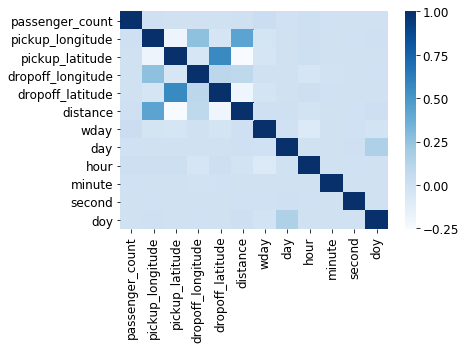

In [16]:

sns.heatmap(X_train_copy.corr(), cmap='Blues')


In [17]:
X_train_copy.isnull().sum(axis=0).sum(axis=0)

0

In [18]:
y_train.info()
y_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102104 entries, 518559 to 1318674
Data columns (total 1 columns):
trip_duration    102104 non-null int64
dtypes: int64(1)
memory usage: 1.6 MB


,trip_duration
518559,2404
989392,897
99540,494
323455,1669
1062077,671


In [19]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_copy.values, y_train.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [30]:
lin_reg.score(X_train_copy, y_train.values)

0.023148531847391185

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
#rf_clf = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42)
#y_train.values
#X_train_copy.values
#rf_clf.fit(X_train_copy, y_train)

In [22]:
#rf_clf.fit(X_train_copy.values.ravel(), y_train.values.ravel())

In [23]:
#rf_clf.score(X_val, y_val)

In [24]:
#importances = rf_clf.feature_importances_

In [25]:
#indices = np.argsort(importances)[::-1]

In [26]:
#for f in range(10): 
#    print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')